Apple Stock (AAPL) Machine Learning Binary Classification

In [569]:
#Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

In [570]:
raw_df = yf.download('AAPL', start = '2010-01-01', end = '2025-07-26')
df = raw_df.copy() 

/var/folders/1p/bkw8vf0537qgpg1zgyfwq80r0000gn/T/ipykernel_93423/1667098571.py:1: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


In [571]:
raw_df.head()

Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2010-01-04,6.431896,6.446622,6.382907,6.414464,493729600
2010-01-05,6.443017,6.479383,6.409055,6.449629,601904800
2010-01-06,6.340531,6.468562,6.333919,6.443016,552160000
2010-01-07,6.328810,6.371487,6.282827,6.363974,477131200
2010-01-08,6.370886,6.371488,6.283129,6.320395,447610800


In [572]:
df.columns = df.columns.droplevel(1)

In [573]:
df.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2010-01-04,6.431896,6.446622,6.382907,6.414464,493729600
2010-01-05,6.443017,6.479383,6.409055,6.449629,601904800
2010-01-06,6.340531,6.468562,6.333919,6.443016,552160000
2010-01-07,6.328810,6.371487,6.282827,6.363974,477131200
2010-01-08,6.370886,6.371488,6.283129,6.320395,447610800


In [574]:
df = df.reset_index()
df = df[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']]

In [575]:
df.head()

Price,Date,Close,Open,High,Low,Volume
0,2010-01-04,6.431896,6.414464,6.446622,6.382907,493729600
1,2010-01-05,6.443017,6.449629,6.479383,6.409055,601904800
2,2010-01-06,6.340531,6.443016,6.468562,6.333919,552160000
3,2010-01-07,6.328810,6.363974,6.371487,6.282827,477131200
4,2010-01-08,6.370886,6.320395,6.371488,6.283129,447610800


In [576]:
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)
df = df.dropna()
df.head()

Price,Date,Close,Open,High,Low,Volume,Target
0,2010-01-04,6.431896,6.414464,6.446622,6.382907,493729600,1
1,2010-01-05,6.443017,6.449629,6.479383,6.409055,601904800,0
2,2010-01-06,6.340531,6.443016,6.468562,6.333919,552160000,0
3,2010-01-07,6.328810,6.363974,6.371487,6.282827,477131200,1
4,2010-01-08,6.370886,6.320395,6.371488,6.283129,447610800,0


In [577]:
#1-day return to capture the momentum of the stock
df['Return_1d'] = df['Close'].pct_change()

In [578]:
#5-day return
df['Return_5d'] = df['Close'].pct_change(5)
#2 and 3 day returns
df['Return_2d'] = df['Close'].pct_change(2)
df['Return_3d'] = df['Close'].pct_change(3)
df['Return_10d'] = df['Close'].pct_change(10)

In [579]:
#Moving averages for 10 days and 50 days, and their ratio
df['MA_10'] = df['Close'].rolling(10).mean()
df['MA_50'] = df['Close'].rolling(50).mean()
df['MA_ratio'] = df['MA_10'] / df['MA_50']

In [580]:
#5-day and 10-day volatility (standard deviation of returns)
df['Volatility_5d'] = df['Return_1d'].rolling(5).std()
df['Volatility_10d'] = apple_df['Return_1d'].rolling(10).std()

In [581]:
#Date-Based Features
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week

In [582]:
#Volume Ratio
df['Volume_MA'] = df['Volume'].rolling(10).mean()
df['Volume_Ratio'] = df['Volume'] / df['Volume_MA']

In [583]:
#Return within a single day
df['IntraDay_Return'] = (df['Close'] - df['Open']) / df['Open']

In [584]:
#Daily Range: How much the stock moved within a day
df['Daily_Range'] = (df['High'] - df['Low']) / df['Close']

In [585]:
#14 day RSI
window = 14
delta = df['Close'].diff()
gain = delta.clip(lower = 0)
loss = - delta.clip(upper = 0)
avg_gain = gain.rolling(window).mean()
avg_loss = loss.rolling(window).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

In [586]:
df.columns

Index(['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Target', 'Return_1d',
       'Return_5d', 'Return_2d', 'Return_3d', 'Return_10d', 'MA_10', 'MA_50',
       'MA_ratio', 'Volatility_5d', 'Volatility_10d', 'DayOfWeek', 'Month',
       'Week', 'Volume_MA', 'Volume_Ratio', 'IntraDay_Return', 'Daily_Range',
       'RSI'],
      dtype='object', name='Price')

In [587]:
fig = px.line(df, x = 'Date', y = 'Close', title = 'Apple Stock (AAPL) Close Price (2010–2025)')
fig.update_xaxes(title_text = "Date")
fig.update_yaxes(title_text = "Adjusted Close Price (USD)")
fig.show()

In [588]:
stock_df = df[['Target', 
               'Return_1d', 'Return_2d', 'Return_3d',
               'Return_5d', 'Return_10d', 'MA_ratio', 'Volatility_5d', 'Volatility_10d',
               'Volume_Ratio', 'IntraDay_Return', 'Daily_Range',
               'DayOfWeek', 'Month', 'Week', 'RSI']].dropna()

In [589]:
stock_df.head()

Price,Target,Return_1d,Return_2d,Return_3d,Return_5d,Return_10d,MA_ratio,Volatility_5d,Volatility_10d,Volume_Ratio,IntraDay_Return,Daily_Range,DayOfWeek,Month,Week,RSI
49,0,0.002725,-0.009488,-0.004656,0.006412,0.074695,1.066074,0.007847,0.020178,0.835886,0.001204,0.011005,1,3,11,90.199210
50,1,-0.001470,0.001251,-0.010944,-0.003202,0.070654,1.072173,0.006863,0.018007,0.831192,-0.003468,0.014189,2,3,11,88.698279
51,0,0.002365,0.000891,0.003619,-0.003770,0.066157,1.077834,0.006794,0.022607,0.633362,0.002454,0.010639,3,3,11,87.806611
52,1,-0.010683,-0.008344,-0.009802,-0.019197,0.015072,1.078252,0.007134,0.022347,1.105337,-0.011299,0.018043,4,3,11,77.039130
53,1,0.011249,0.000445,0.002811,0.004066,0.025881,1.079510,0.007943,0.022779,0.897079,0.019413,0.026029,0,3,12,79.576011


In [590]:
stock_df.shape

(3816, 16)

In [591]:
stock_df = stock_df.reset_index(drop = True)

In [592]:
px.histogram(stock_df, x = 'Return_1d', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [593]:
px.histogram(stock_df, x = 'Return_2d', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [594]:
px.histogram(stock_df, x = 'Return_3d', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [595]:
px.histogram(stock_df, x = 'Return_5d', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [596]:
px.histogram(stock_df, x = 'MA_ratio', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [597]:
px.histogram(stock_df, x = 'Volatility_5d', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [598]:
px.histogram(stock_df, x = 'Volume_Ratio', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [599]:
px.histogram(stock_df, x = 'IntraDay_Return', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [600]:
px.histogram(stock_df, x = 'Daily_Range', color = 'Target', color_discrete_sequence = ['red', 'blue'])

In [601]:
px.histogram(stock_df, x = 'RSI', color = 'Target', color_discrete_sequence = ['red', 'blue'])

<Axes: xlabel='Target', ylabel='count'>

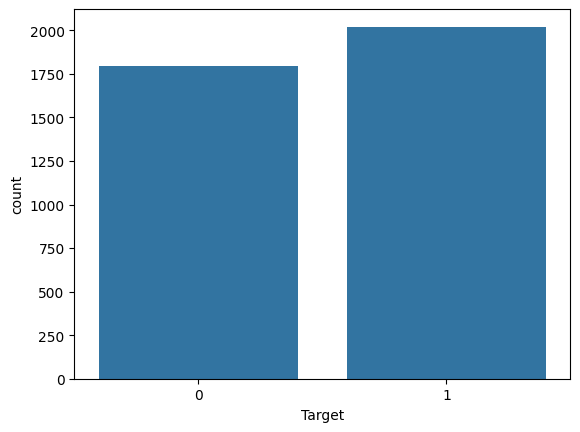

In [602]:
sns.countplot(data = stock_df, x = 'Target')

<Axes: xlabel='Target', ylabel='Daily_Range'>

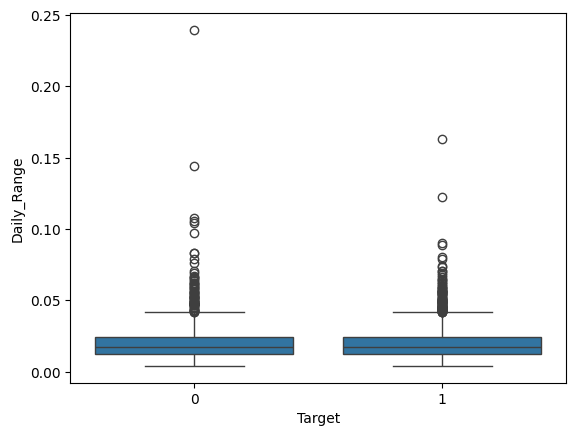

In [603]:
sns.boxplot(data = stock_df, x = 'Target', y = 'Daily_Range')

In [604]:
px.scatter(stock_df, x = 'Return_1d', y = 'Volatility_5d', color = stock_df['Target'].astype(str), color_discrete_sequence = ['red', 'blue'])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

divide by zero encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

overflow encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

invalid value encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

divide by zero encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

overflow encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/scipy/_lib/_util.py:1272: RuntimeWarning:

invalid value encountered in vecdot

/Library/Frameworks/Python.framework/Versions/3.

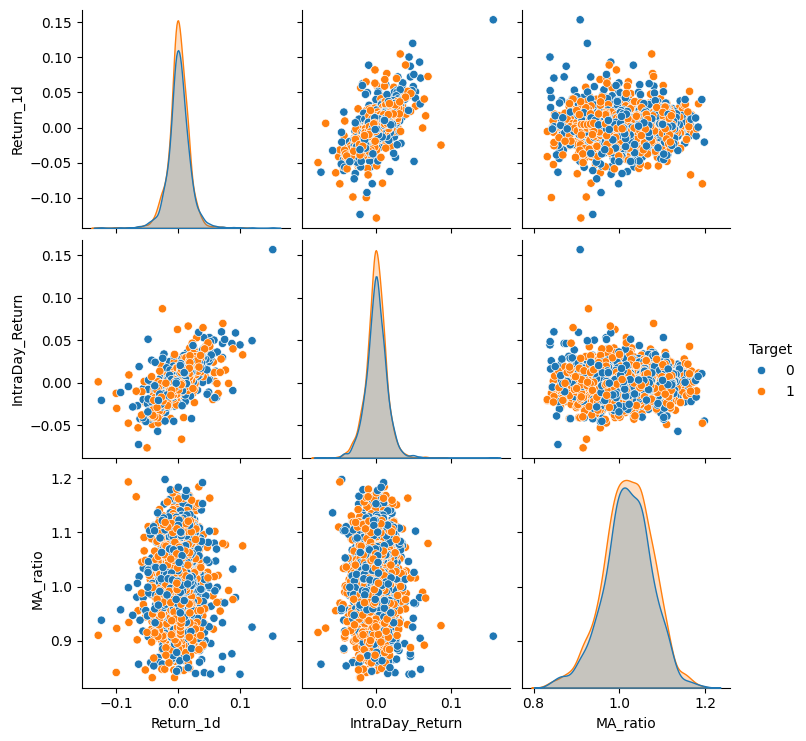

In [605]:
sns.pairplot(stock_df[['Return_1d', 'IntraDay_Return', 'MA_ratio', 'Target']], hue = 'Target')

In [606]:
numerical_columns = ['Return_1d', 'Return_2d', 'Return_3d', 'Return_5d', 'Return_10d',
                     'MA_ratio', 'Volatility_5d', 'Volatility_10d', 'Volume_Ratio',
                     'IntraDay_Return', 'Daily_Range', 'RSI']
#categorical_columns = ['DayOfWeek'] #, 'Month', 'Week']
X_inputs = stock_df[numerical_columns] # + categorical_columns]
Y_targets = stock_df['Target']

In [607]:
X_train, X_test, y_train, y_test = train_test_split(
    X_inputs, Y_targets, test_size = 0.2, shuffle = False
)

In [608]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3052, 12), (764, 12), (3052,), (764,))

In [609]:
#Preprocessing with OneHotEncoding and MinMaxScaling (-1, 1)
preprocessor = ColumnTransformer(
    transformers = [
        ('numerical', MinMaxScaler(feature_range = (-1, 1)), numerical_columns),
        #('categorical', OneHotEncoder(drop = None, sparse_output = False), categorical_columns)
    ]
)

In [610]:
#Model pipeline -> Preproccessing + Logistic Regression
model = Pipeline(
    steps = [
        ('preprocess', preprocessor),
        ('classifier', LogisticRegression(max_iter = 1000, C = 0.1))
    ]
)

In [611]:
#FIt the model using training data
model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:200: RuntimeWarning:

invalid value encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_linear_loss.py:330: Runtim

,steps,"[('preprocess', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('numerical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [612]:
X_train

Price,Return_1d,Return_2d,Return_3d,Return_5d,Return_10d,MA_ratio,Volatility_5d,Volatility_10d,Volume_Ratio,IntraDay_Return,Daily_Range,RSI
0,0.002725,-0.009488,-0.004656,0.006412,0.074695,1.066074,0.007847,0.020178,0.835886,0.001204,0.011005,90.199210
1,-0.001470,0.001251,-0.010944,-0.003202,0.070654,1.072173,0.006863,0.018007,0.831192,-0.003468,0.014189,88.698279
2,0.002365,0.000891,0.003619,-0.003770,0.066157,1.077834,0.006794,0.022607,0.633362,0.002454,0.010639,87.806611
3,-0.010683,-0.008344,-0.009802,-0.019197,0.015072,1.078252,0.007134,0.022347,1.105337,-0.011299,0.018043,77.039130
4,0.011249,0.000445,0.002811,0.004066,0.025881,1.079510,0.007943,0.022779,0.897079,0.019413,0.026029,79.576011
...,...,...,...,...,...,...,...,...,...,...,...,...
3047,-0.004844,-0.005854,0.008178,-0.023357,-0.031485,1.002807,0.015956,0.019634,1.173149,-0.014742,0.033770,36.803111
3048,-0.027821,-0.032530,-0.033512,-0.021175,-0.060125,0.998350,0.015101,0.019969,1.130524,-0.028055,0.039372,32.296444
3049,0.006737,-0.021271,-0.026012,-0.013267,-0.042389,0.995133,0.015892,0.017960,1.246879,0.010924,0.028917,25.928194
3050,-0.037328,-0.030842,-0.057805,-0.063321,-0.053997,0.991175,0.018782,0.018549,1.204822,-0.033590,0.035842,23.929214


In [613]:
#cat_features = model.named_steps['preprocess'].named_transformers_['categorical'].get_feature_names_out(categorical_columns)

In [614]:
X_train_scaled = model.named_steps['preprocess'].transform(X_train)
X_train_scaled

array([[ 0.05751244, -0.02631069, -0.06738388, ..., -0.07505183,
        -0.94177431,  0.845437  ],
       [ 0.0237406 ,  0.05130033, -0.11026803, ..., -0.13362691,
        -0.91472664,  0.81360631],
       [ 0.05461067,  0.048699  , -0.01094544, ..., -0.0593815 ,
        -0.94488211,  0.79469643],
       ...,
       [ 0.08980568, -0.11146805, -0.2130323 , ...,  0.04678915,
        -0.78961643, -0.51757754],
       [-0.26490557, -0.18063698, -0.42986817, ..., -0.51123754,
        -0.73079248, -0.55997052],
       [ 0.02376703, -0.23771214, -0.25567256, ..., -0.03708164,
        -0.79599333, -0.51242521]], shape=(3052, 12))

In [615]:
X_train_scaled_df = pd.DataFrame(data = X_train_scaled, columns = numerical_columns)
X_train_scaled_df

,Return_1d,Return_2d,Return_3d,Return_5d,Return_10d,MA_ratio,Volatility_5d,Volatility_10d,Volume_Ratio,IntraDay_Return,Daily_Range,RSI
0,0.057512,-0.026311,-0.067384,0.011101,0.298504,0.279758,-0.866893,-0.560813,-0.689362,-0.075052,-0.941774,0.845437
1,0.023741,0.051300,-0.110268,-0.042393,0.279870,0.313086,-0.885354,-0.617399,-0.691975,-0.133627,-0.914727,0.813606
2,0.054611,0.048699,-0.010945,-0.045551,0.259131,0.344019,-0.886660,-0.497504,-0.802078,-0.059382,-0.944882,0.794696
3,-0.050421,-0.018040,-0.102474,-0.131388,0.023534,0.346305,-0.880264,-0.504278,-0.539399,-0.231800,-0.881988,0.566347
4,0.126123,0.045477,-0.016454,-0.001955,0.073382,0.353177,-0.865097,-0.493008,-0.655306,0.153213,-0.814148,0.620148
...,...,...,...,...,...,...,...,...,...,...,...,...
3047,-0.003415,-0.000050,0.020151,-0.154536,-0.191178,-0.065979,-0.714679,-0.574996,-0.501658,-0.274951,-0.748392,-0.286950
3048,-0.188377,-0.192831,-0.264187,-0.142395,-0.323264,-0.090340,-0.730730,-0.566266,-0.525381,-0.441847,-0.700805,-0.382524
3049,0.089806,-0.111468,-0.213032,-0.098396,-0.241468,-0.107917,-0.715888,-0.618631,-0.460623,0.046789,-0.789616,-0.517578
3050,-0.264906,-0.180637,-0.429868,-0.376903,-0.294999,-0.129549,-0.661636,-0.603277,-0.484030,-0.511238,-0.730792,-0.559971


In [616]:
#Predict using model
y_train_pred = model.predict(X_train)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



In [617]:
weights_by_feature = pd.DataFrame(
    {
        'features': (numerical_columns),
        'weights': model.named_steps['classifier'].coef_[0]
    }
).sort_values(
    by = 'weights',
    key = abs, 
    ascending = False
).reset_index(drop = True)

In [618]:
weights_by_feature.head()

,features,weights
0,Return_5d,0.222073
1,IntraDay_Return,-0.208390
2,Return_1d,-0.205722
3,Return_10d,-0.172476
4,Volume_Ratio,0.143042


In [619]:
# Accuracy
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))

Train Accuracy: 0.5350589777195282


In [620]:
# Test Accuracy
y_test_pred = model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))

Test Accuracy: 0.518324607329843


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

divide by zero encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

overflow encountered in matmul

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning:

invalid value encountered in matmul



In [621]:
cm = confusion_matrix(y_test, y_test_pred, normalize = 'true')

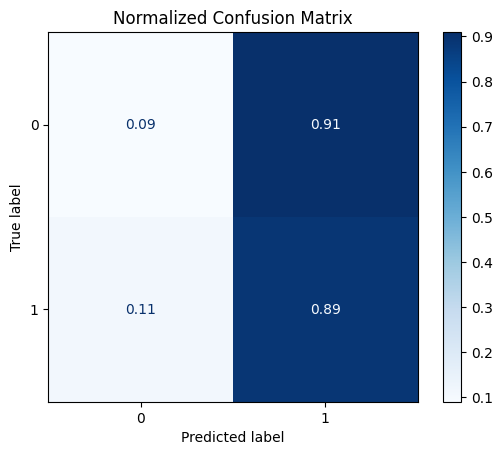

In [622]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model.classes_)
disp.plot(cmap = 'Blues', values_format = ".2f")
plt.title("Normalized Confusion Matrix")
plt.show()